# (IID rotations) MNIST
Diagonal online Laplace with a replay buffer v.s. diagonal LoFi

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rebayes.utils.utils import get_subtree

In [66]:
plt.rcParams["font.size"] = 14

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
kmode = "valid"
ksize = 200
kernel = np.ones(ksize) / ksize

## Hyperparameter optimisation

In [ ]:
%%time
%run rotating_mnist_unsorted.py uniform

Training RSGD
Memory size: 1
|   iter    |  target   |  log_lr   |
-------------------------------------
| 1         | -4.235    | -11.38    |
| 2         | -0.2508   | -9.025    |
| 3         | 0.4056    | -7.787    |
| 4         | -21.73    | -14.96    |
| 5         | -13.41    | -14.28    |
| 6         | -21.38    | -14.94    |
| 7         | -2.953    | -10.72    |
| 8         | -3.331    | -10.91    |
| 9         | -1e+10    | -7.556    |
| 10        | -1e+10    | -7.592    |
| 11        | 0.6139    | -8.001    |
| 12        | -16.62    | -14.57    |
| 13        | 0.08029   | -8.721    |
| 14        | -4.244    | -11.38    |
| 15        | 0.08104   | -8.721    |
| 16        | -16.62    | -14.57    |
| 17        | -0.6658   | -9.391    |
| 18        | -1.178    | -9.749    |


## Building agent

In [78]:
%%time
agents = {}

for memory, optimiser_rsgd in rsgd_optimisers.items():
    lr = np.exp(optimiser_rsgd.max["params"]["log_lr"])
    tx = optax.sgd(lr)

    agent_rsgd = rsgd.init_regression_agent(
        key, part_log_likelihood, model, X_train, tx, memory,
        lossfn=part_lossfn,
        prior_precision=1 / initial_covariance,
    )
    
    name = f"r-sgd-{memory:02}"
    agents[name] = agent_rsgd

for memory, optimiser_adam in adam_optimisers.items():
    lr = np.exp(optimiser_adam.max["params"]["log_lr"])
    tx = optax.adam(lr)

    agent_adam = rsgd.init_regression_agent(
        key, part_log_likelihood, model, X_train, tx, memory,
        lossfn=part_lossfn,
        prior_precision=1 / initial_covariance,
    )
    
    name = f"r-adam-{memory:02}"
    agents[name] = agent_adam

for memory, optimiser_lofi in lofi_optimisers.items():
    dynamics_covariance = np.exp(optimiser_lofi.max["params"]["log_dynamics_covariance"])
    dynamics_weights = 1 - np.exp(optimiser_lofi.max["params"]["log_1m_dynamics_weights"])

    agent_lofi, rfn = lofi.init_regression_agent(
        key, model, X_train,
        initial_covariance, dynamics_weights, dynamics_covariance,
        emission_cov, memory
    )
    name = f"lofi-{memory:02}"
    agents[name] = agent_lofi

CPU times: user 681 ms, sys: 73.5 ms, total: 754 ms
Wall time: 530 ms


## Run agents

In [79]:
callback = partial(callbacks.cb_reg_mc,
                ymean=ymean, ystd=ystd,
                X_test=X_test, y_test=Y_test,
                key=key,
)

In [27]:
%%time
outputs = {}
bel_agents = {}

for name_agent, agent in agents.items():
    print(name_agent)
    if "lofi" in name_agent:
        applyfn = agent.params.emission_mean_function
    else:
        applyfn = agent.apply_fn
        
    callback_agent = partial(callback, apply_fn=applyfn, agent=agent)
    bel_agent, output_agent = agent.scan(X_train, Y_train, progress_bar=True, callback=callback_agent)
    output_agent = tree_to_cpu(output_agent)
    
    outputs[name_agent] = output_agent
    bel_agents[name_agent] = bel_agent

r-sgd-01


  0%|          | 0/5458 [00:00<?, ?it/s]

r-sgd-05


  0%|          | 0/5458 [00:00<?, ?it/s]

r-sgd-10


  0%|          | 0/5458 [00:00<?, ?it/s]

r-adam-01


  0%|          | 0/5458 [00:00<?, ?it/s]

r-adam-05


  0%|          | 0/5458 [00:00<?, ?it/s]

r-adam-10


  0%|          | 0/5458 [00:00<?, ?it/s]

lofi-05


  0%|          | 0/5458 [00:00<?, ?it/s]

lofi-10


  0%|          | 0/5458 [00:00<?, ?it/s]

lofi-20


  0%|          | 0/5458 [00:00<?, ?it/s]

lofi-50


  0%|          | 0/5458 [00:00<?, ?it/s]

CPU times: user 5min 1s, sys: 8.12 s, total: 5min 9s
Wall time: 5min 13s


## Store outputs

In [91]:
dir_output = "../../figures/"
task_name = "iid-rotation"

optimisers = {
    "rsgd": rsgd_optimisers,
    "adam": adam_optimisers,
    "lofi": lofi_optimisers
}

In [92]:
import os
import pickle

path_base = f"../../outputs/gradually-rotating-reg"

path_target = os.path.join(path_base, f"{task_name}-outputs.pkl")
with open(path_target, "wb") as f:
    pickle.dump(outputs, f)
    
    
path_target = os.path.join(path_base, f"{task_name}-optimisers.pkl")
with open(path_target, "wb") as f:
    pickle.dump(optimisers, f)

## Plot results

In [43]:
colors = {
    "lofi-05": plt.cm.Blues(0.3),
    "lofi-10": plt.cm.Blues(0.6),
    "lofi-20": plt.cm.Blues(0.8),
    "lofi-50": plt.cm.Blues(0.8),
    
    "r-adam-01": plt.cm.Reds(0.3),
    "r-adam-05": plt.cm.Reds(0.65),
    "r-adam-10": plt.cm.Reds(1.0),
    
    "r-sgd-01": plt.cm.Greens(0.3),
    "r-sgd-05": plt.cm.Greens(0.65),
    "r-sgd-10": plt.cm.Greens(1.0),    
}

### RMSE

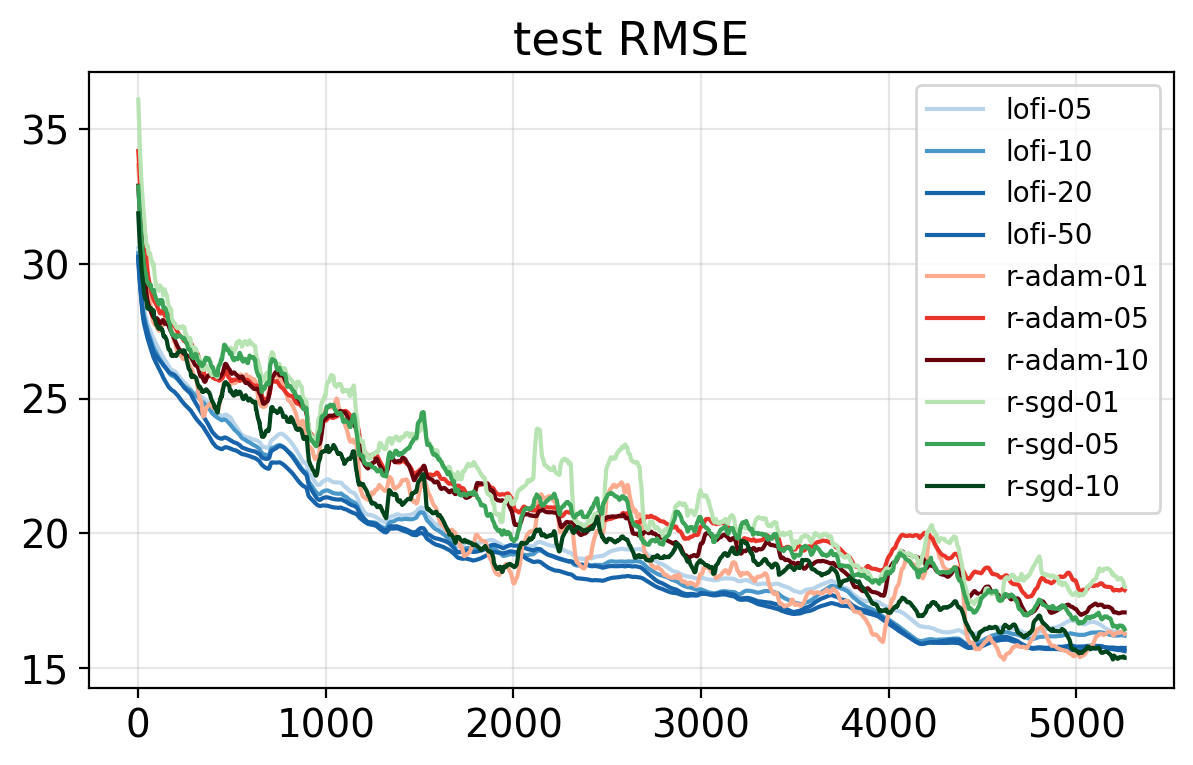

In [71]:
metric = "test-metric"
title = "test RMSE"

outputs_metric = get_subtree(outputs, metric)
outputs_metric = jax.tree_map(lambda x: np.convolve(x, kernel, mode=kmode), outputs_metric)

fig, ax = plt.subplots(figsize=(7, 4))
for name_agent, metric_agent in outputs_metric.items():
    plt.plot(metric_agent, label=name_agent, color=colors[name_agent])

# metric_agent = outputs["lofi-10"][metric]
# vmin = np.quantile(metric_agent, 0.00)
# vmax = np.quantile(metric_agent, 1.0)
# plt.ylim(vmin, vmax)

plt.title(title)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

namefile = f"test-rmse-all.pdf"
namefile = os.path.join(dir_output, f"{task_name}-{namefile}")
plt.savefig(namefile)

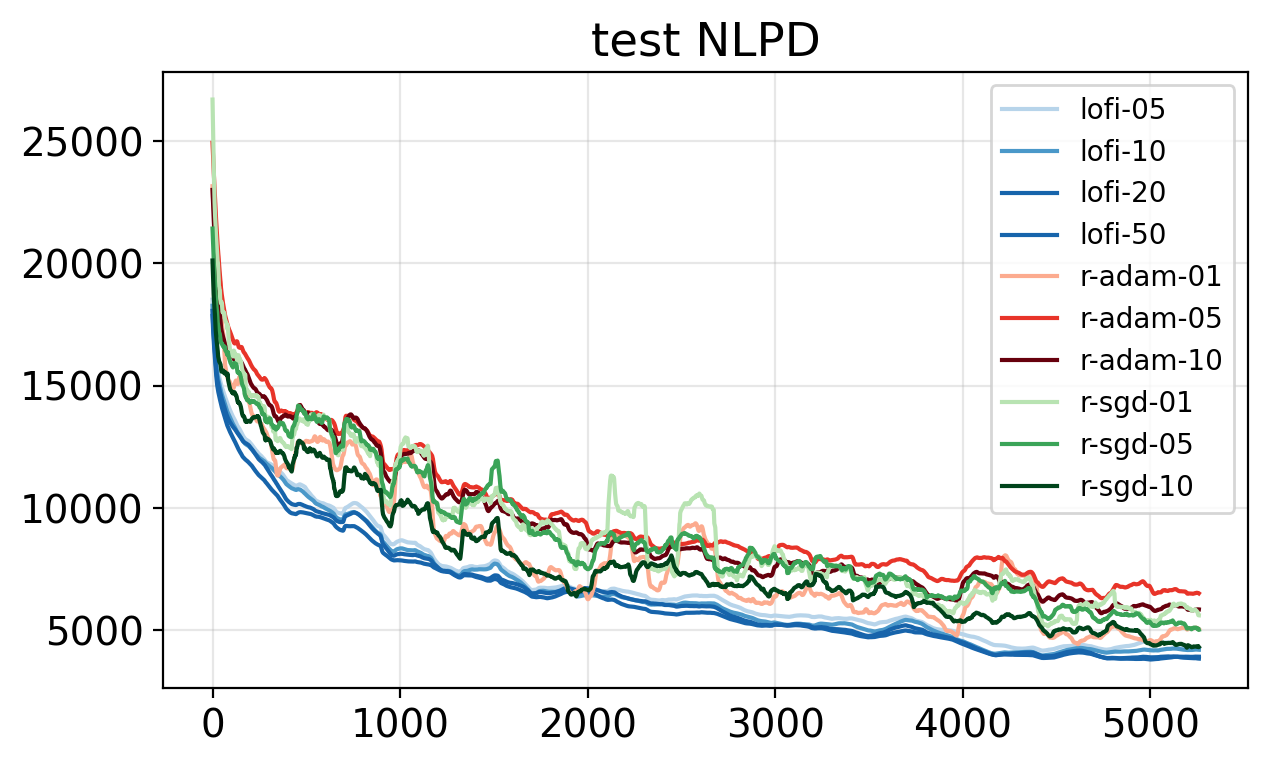

In [72]:
metric = "nlpd_test"
title = "test NLPD"

outputs_metric = get_subtree(outputs, metric)
outputs_metric = jax.tree_map(lambda x: np.convolve(x, kernel, mode=kmode), outputs_metric)

fig, ax = plt.subplots(figsize=(7, 4))
for name_agent, metric_agent in outputs_metric.items():
    plt.plot(metric_agent, label=name_agent, color=colors[name_agent])

plt.title(title)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

namefile = f"test-nlpd-all.pdf"
namefile = os.path.join(dir_output, f"{task_name}-{namefile}")
plt.savefig(namefile)

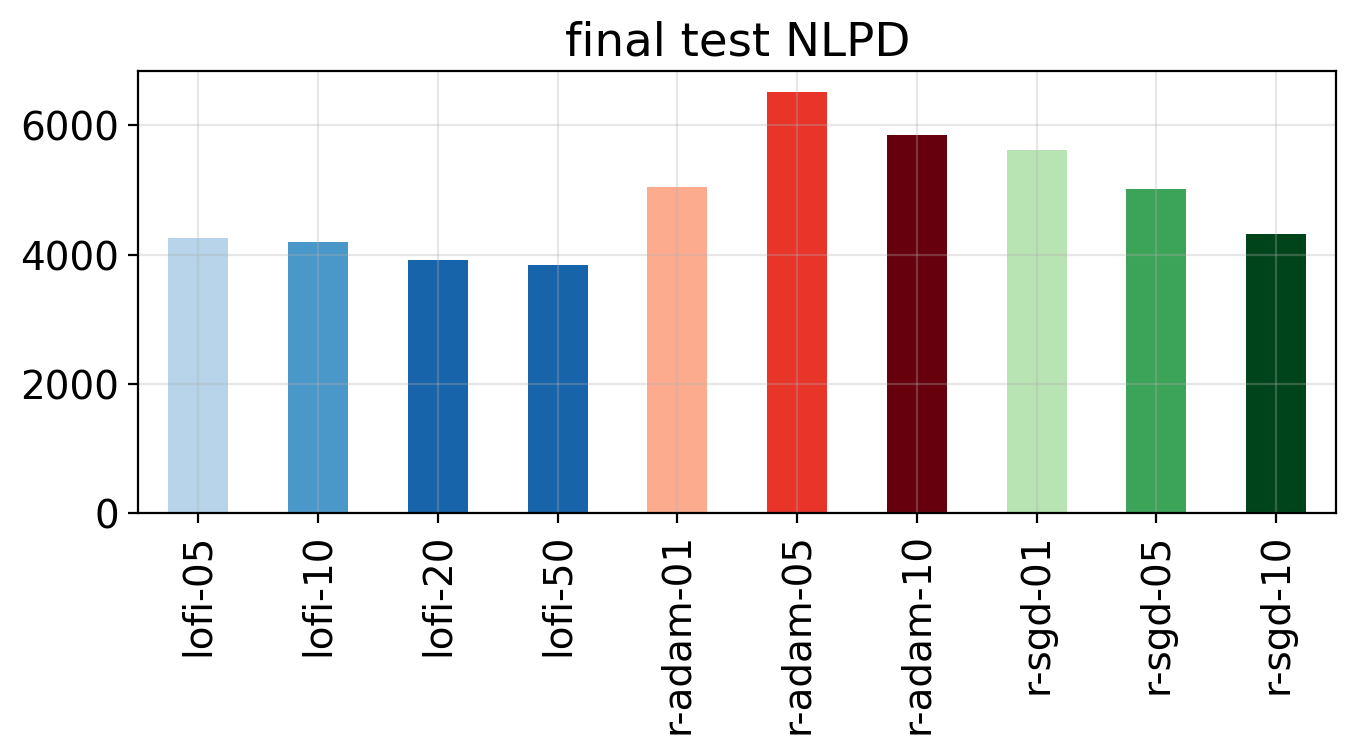

In [77]:
fig, ax = plt.subplots(figsize=(7, 4))

pd.DataFrame(outputs_metric).iloc[-1].plot(kind="bar", color=colors.values(), ax=ax)
plt.title("final test NLPD")
plt.grid(alpha=0.3)
plt.tight_layout()
namefile = f"test-nlpd-all-final.pdf"
namefile = os.path.join(dir_output, f"{task_name}-{namefile}")
plt.savefig(namefile)

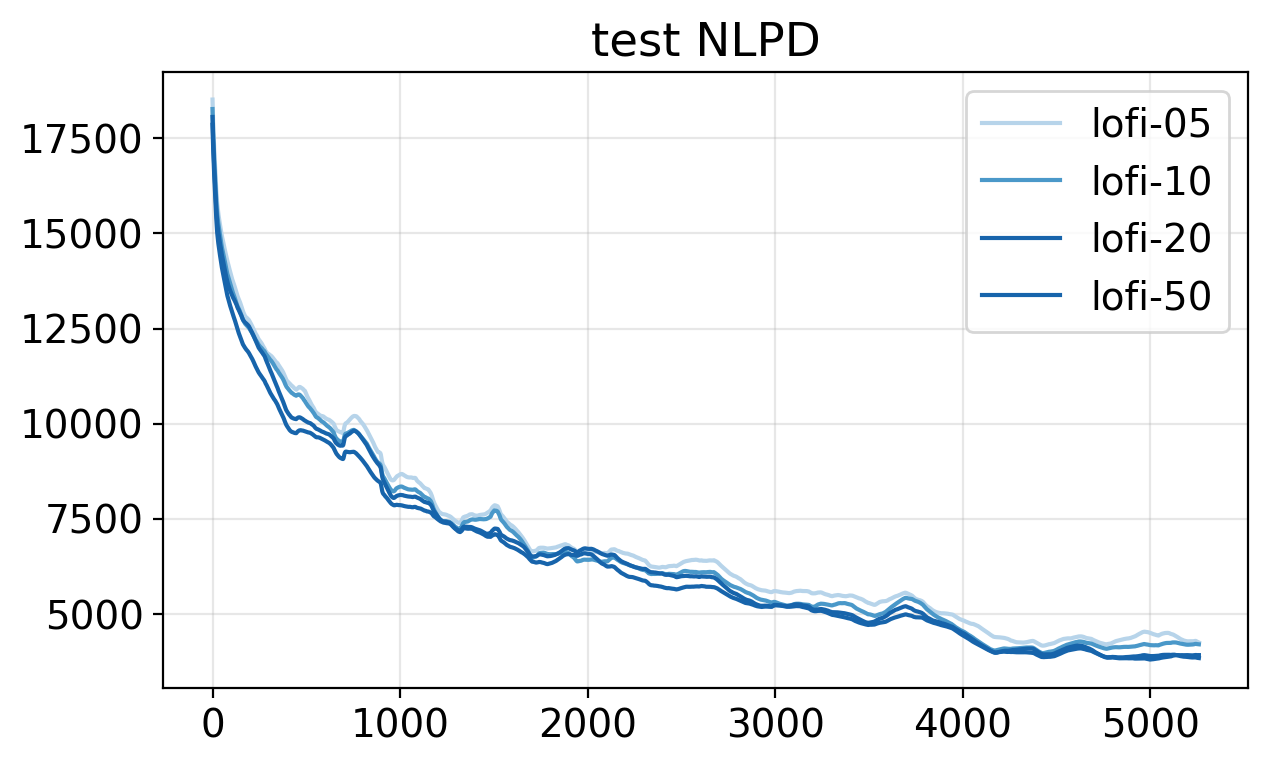

In [74]:
metric = "nlpd_test"
title = "test NLPD"

outputs_metric = get_subtree(outputs, metric)
outputs_metric = jax.tree_map(lambda x: np.convolve(x, kernel, mode=kmode), outputs_metric)

fig, ax = plt.subplots(figsize=(7, 4))
for name_agent, metric_agent in outputs_metric.items():
    if "lofi" not in name_agent:
        continue
    plt.plot(metric_agent, label=name_agent, color=colors[name_agent])

plt.title(title)
plt.legend()
plt.grid(alpha=0.3)

namefile = f"test-nlpd-lofi.pdf"
namefile = os.path.join(dir_output, f"{task_name}-{namefile}")
plt.savefig(namefile)